## Unsupervised Machine Learning - Notes from mysefl to future myself 

### 1. Motivation
In this example i chosed my smallest work, which has initial resolution of 6454 x 13484. I'm working on my own startup relate to damage calculation using photogrammety images captured by drone. If i manage to detect corn or other crops i can move to calculate damage on selected chunks to automate process of identifying damage, marking it and finally calculate totad damage on selected area

### 2. Image
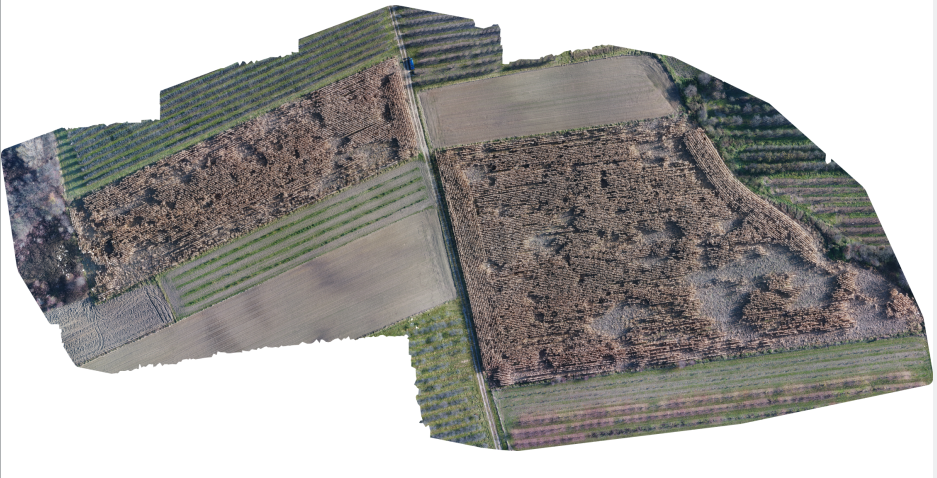

### 3. Source
To implement this soultion ill be deriving from this [python notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb), grabbed from this [stacoverflow question](https://stackoverflow.com/questions/55681649/how-to-build-an-unsupervised-cnn-model-with-keras-tensorflow) 
*note*
This answer is provided by TensorFlow Support which i find quite funny

### 4. Parsing images
It turns out that `.tiff` file extension is not parsable by `tf.keras.preprocessing.image.ImageDataGenerator` method, therefore you need to do it by hand with `tfio.experimental.image.decode_tiff`.

### 5. Setup:

In [2]:
# some preparation to make it:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-05-05 13:12:18.260999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 13:12:18.307295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 13:12:18.308041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 13:12:19.078975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
def parse_tiff(img_path: str):
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(str(img_path))
    image = tfio.experimental.image.decode_tiff(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image

In [5]:
train_dataset = tf.data.Dataset.list_files("./splited/train/tiles_test/*.tif", seed=1337)
train_dataset = train_dataset.map(parse_tiff)
train_dataset = train_dataset.batch(32)
val_dataset = tf.data.Dataset.list_files("./splited/val/tiles_test/*.tif", seed=1337)
val_dataset = val_dataset.map(parse_tiff)

2023-05-05 13:12:29.188815: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [14]:
print(type(val_dataset))
print(train_dataset)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<_BatchDataset element_spec=TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)>
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [15]:
import tensorflow as tf
#import tensorflow_io as tfio
# tfio.experimental.image.decode_tiff
import os

TRAIN = "./splited/train/tiles_test/"
files = [TRAIN+str(x) for x in os.listdir(TRAIN)]
print(len(files))

parsed = np.array([parse_tiff(x) for x in files], dtype=np.ndarray)

4238


## Stacked Autoencoders

In [ ]:
train_dataset = tf.data.Dataset.list_files("./splited/train/tiles_test/*.tif", seed=1337)
train_dataset = train_dataset.map(parse_tiff)
train_dataset = train_dataset.batch(32)
val_dataset = tf.data.Dataset.list_files("./splited/val/tiles_test/*.tif", seed=1337)
val_dataset = val_dataset.map(parse_tiff)


In [9]:
# TODO: Explain this 

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/5


2023-05-05 13:15:17.738280: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: Tensor("args_0:0", shape=(), dtype=string); No such file or directory
2023-05-05 13:15:17.738436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): NOT_FOUND: Tensor("args_0:0", shape=(), dtype=string); No such file or directory
	 [[{{node ReadFile}}]]


ValueError: in user code:

    File "/home/kobala/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/kobala/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kobala/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/kobala/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/kobala/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1006, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=sparse_categorical_crossentropy, and therefore expects target data to be provided in `fit()`.


In [17]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(train_dataset, train_dataset,
                      batch_size=32, epochs=100,
                      validation_data=(val_dataset, val_dataset))

ValueError: `y` argument is not supported when using dataset as input.

In [20]:
# Call neural network API

model = keras.models.Sequential()
# Apply linear activation function to input layer
# Generate hidden layer with 14 nodes, the same as the input layer
model.add(tf.keras.layers.Dense(units=14, activation='linear',input_dim=14))
model.add(tf.keras.layers.Dense(units=14, activation='linear'))
# Apply linear activation function to hidden layer
# Generate output layer with 14 nodes
model.add(tf.keras.layers.Dense(units=14, activation='linear'))
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [21]:
# Train the model
num_epochs = 10
batch_size = 256
history = model.fit(x=train_dataset, y=train_dataset,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(train_dataset, train_dataset),
                    verbose=1)

ValueError: `y` argument is not supported when using dataset as input.